# Tutorial 2- Optimal Control for Continuous State

Please execute the cell below to initialize the notebook environment.

In [1]:
import numpy as np                 # import numpy
import scipy               # import scipy
import random                      # import basic random number generator functions
from scipy.linalg import inv

import matplotlib.pyplot as plt    # import matplotlib

---

## Tutorial objectives

In this tutorial, we will implement the linear qudratic regulator (LQR) in 1D case.

---

## Quadratic cost function 

In general, a linear discrete-time system with noise has the dynamic:

\begin{equation*}
x_{t+1} = Dx_t + Ba_t + w_t 
\end{equation*}

with 

$x_t$: state at time $t$ 

$a_t$: control at time $t$

$w_t$: noise at time $t$

$D$ and $B$: parameters of the linear dynamical system  

For 1D case, $D$, $B$, $Q$, $R$ are all scalars.

In LQR problem,  a quadratic cost function is defined as: 

$$ J(x, a) = \sum_{t = 0}^{T-1} (Q x_{t}^2 + R a_{t}^2) + Q_T x_{T}^2$$

where $Q$ and $Q_N$ are the state cost matrices, and $R$ is the control cost matrix. 



The goal of the LQR problem is to find control $\{a_t\}_{t=0}^{T-1}$ such that $J(x, u)$ is minimized. For 1D case specially, the goal is then to find the control gain at each time point, i,.e.

$$ \text{argmin} _{K_t}  J(x, a) $$ 

where $a_t = K_t x_t$.

### Exercise 1: Control to the origin

In this exercise, we will use a time-invariant control to test the trajectory of the states. 

For simplicity, we will apply the LQR control on a 1D case, where the matrices reduce to scalars, and the states, control and noise are one-dimensional as well. 

** Suggestions **
* In function `dynamics_zero_state( )`, complete the code for control *a*, and use that complete the dynamical updating function for state *x*.
* Set the controller gain to be a constant over time. You can play with this parameter to compare the dynamics. 
* Compute the mean square error (MSE) of the states with control and the target states (zero state in the case). 
* With the provided plotting functions, plot the states over time with a particular controller, the histogram of deviation from the zero state, etc.


In [2]:
class LDS_1D:
    def __init__(self, T, ini_state, noise_var, target):
        self.T = T
        self.target = target
        self.ini_state = ini_state
        self.noise_var = noise_var
    
    
    def dynamics_zero_state(self, D, B, Q, R, L):
        #l = self.control_gain_LQR(D, B, Q, R)
        
        x = np.zeros(self.T) # states intialization
        x[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        a = np.zeros(T) # control intialization

        for t in range(self.T - 1):
            a[t] =  - L[t] * x[t] 
            x[t + 1] = D * x[t] + B * a[t] + noise[t]
        
        return a, x
    
    
    def MSE(self, x):
        mse = np.square(x - self.target)
        return mse
    
    def plot_MSE(self, x):
        mse = self.MSE(x)
        
        fig, ax = plt.subplots(1, figsize = (6, 6))
        ax.plot(mse)
        ax.set_xlabel("time", fontsize =14)
        ax.set_ylabel("MSE" , fontsize =14)
        ax.set_title("MSE of the states and the desired trajectory", fontsize =20)
            
    def plot_control(self, u):
        ig, ax = plt.subplots(1, figsize = (6, 6))
        ax.plot(u, 'b')
        ax.set_xlabel("time", fontsize =14)
        ax.set_ylabel("control" , fontsize =14)
        ax.set_title("control over time", fontsize =20)
        
    def plot_position(self, x):        
        fig, ax = plt.subplots(1, figsize = (6, 6))
        ax.plot(x, 'b', label = 'state with control')
        #ax.plot(x_tilde, 'g', label = 'state without control')
        ax.plot(self.target, 'm', label = 'target state')
        ax.set_xlabel("time", fontsize =14)
        ax.set_ylabel("state" , fontsize =14)
        ax.set_title("tacking state", fontsize =20)
        ax.legend(loc="upper right")
        
    def plot_hist(self, x):        
        fig, ax = plt.subplots(1, figsize = (6, 6))
#         ax.hist([x - self.target, x_tilde - self.target], color = ['b', 'g'],
#                label = ['with control', 'without control'])
        ax.hist(x - self.target, color ='b')
        ax.set_ylabel("count" , fontsize =14)
        ax.set_title("histgram of error", fontsize =20)
        
    

In [3]:
D = 1  # state parameter 
B = 1   # control parameter
Q = 1   # cost of state
R = 1   # cost of control
T = 50  # time horizon
ini_state = 4      # initial state
noise_var = 0.2   # process noise

In [4]:
target = np.zeros(T)
lds_zero = LDS_1D(T, ini_state, noise_var, target)
L = - np.ones(T) * .8
a, x = lds_zero.dynamics_zero_state(D, B, Q, R, L)

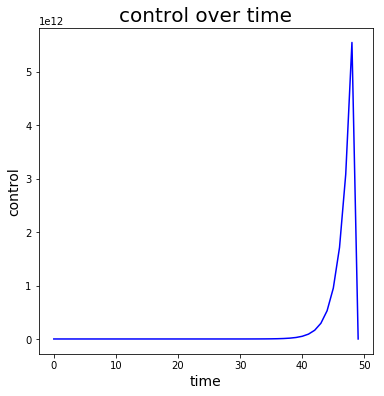

In [5]:
lds_zero.plot_control(a)

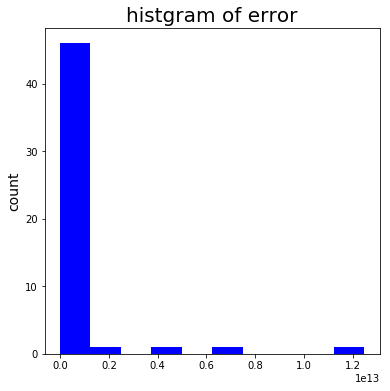

In [6]:
lds_zero.plot_hist(x)

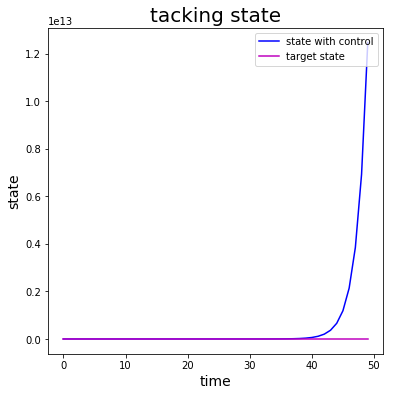

In [7]:
lds_zero.plot_position(x)

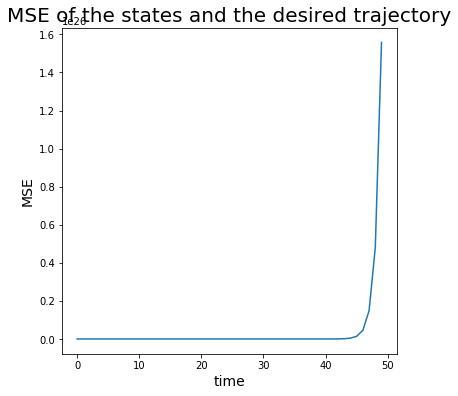

In [8]:
lds_zero.plot_MSE(x)

# LQR

---

## Solving LQR with Dynamic Programming

The solution of LQR can be obtained via Dynamic Programming as follows:
1. set $P_T = Q_T$
2. for $t = T ,...,1$,

    $P_{t-1}  = Q + A^TP_tA - A^TP_tB(R+B^TP_tB)^{-1}B^TP_tA$

3. update the control gain
   
   for $t = T ,...,1$,

    $K^{lqg}_{t-1}  = (R+B^TP_tB)^{-1}B^TP_tA$

4. optimal gain at time $t$ is: $a_t = - K^{lqg}_tx_t$


### Exercise 2: LQR to the origin 

In this exercise, we will design an LQR control for original states, i.e. the state should be zero at all the time. 

** Suggestions **
* We have provided the code in function control_gain( ) for updating *P* iteratively as introduced above. Complete the function to update control gain. Note all the parameters are scalar, and regular math operation should be used instead of numpy matrix operation. 
* Apply the LQR controller, and plot the trajectory of states. 

In [9]:
class LQR_1D(LDS_1D):
    def __init__(self, T, ini_state, noise_var, target):
        super().__init__(T, ini_state, noise_var, target)
    
    
    def control_gain_LQR(self, D, B, Q, R):
        P = np.zeros(self.T) # Riccati updates
        P[-1] = Q  
        
        L = np.zeros(self.T) # control gain 
        
        for t in range(self.T-1):
            P[T - t - 2] = (Q + 
                            P[T - t - 1] * D **2 - 
                            D * P[T - t - 1] * B / (
                                R + P[T - t - 1] * B) * B ** 2 * P[T - t - 1] * D)

            L[T - t - 2] =  (1 / (R + P[T - t - 1] * B ** 2) * B * P[T - t - 1] * D) 
        
        return L
    

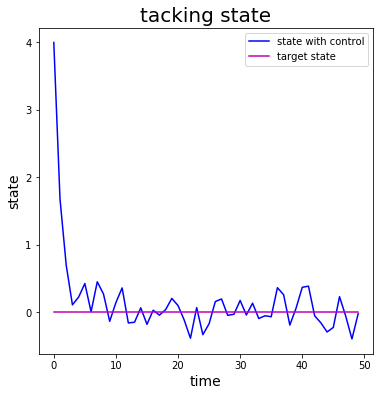

In [10]:
lqr_zero = LQR_1D(T, ini_state, noise_var, target)
L =lqr_zero.control_gain_LQR(D, B, Q, R)
a, x = lds_zero.dynamics_zero_state(D, B, Q, R, L)
lds_zero.plot_position(x)


## LQR for tracking
When the target state, denoted as $\bar{x}$, is not zero staet, the cost function becomes
$$ J(x, a) = \sum_{t = 0}^{T-1} (Q (x_{t}- \bar{x}_t) ^2 + R (a_{t} - \bar{a}_t))^2 + Q_T (x_{T} - \bar{x}_T) ^2$$,

where $\bar{a}_{t}$ is the desired input, i.e. $\bar{x}_{t+1} = Dx_t + B\bar{a}_{t}$.


### Exercise 3: LQR control to desired target
In this excercise, we will use LQR controller to track sinusoid function. 

** Suggestions **
* In the following code, first generate the target trajectory of sinusoid.
* Complete the code in function `dynamics_tracking( )` to update the control. In fact, the function dynamics_tracking( ) is a general version of the function `dynamcis_zero_state( )` in the first excercise, where the latter case takes zero state as the target, while the former one can take any trajectory as target. 

* Use the provided plotting functions to plot the states over time, the control over time, and the histogram of deviation from the target state.

In [11]:
class LQR_1D_tracking(LQR_1D):
    def __init__(self, T, ini_state, noise_var, target):
        super().__init__(T, ini_state, noise_var, target)
    
    
    def dynamics_tracking(self, D, B, Q, R, L):
        
        x = np.zeros(self.T) # states intialization
        x[0] = self.ini_state

        noise = np.random.normal(0, self.noise_var, self.T)
        
        a = np.zeros(T) # control intialization

        for t in range(self.T - 1):
            a[t] =  - L[t] * (x[t] - self.target[t]) + ( - D * x[t] + self.target[t + 1]) / B
            x[t + 1] = D * x[t] + B * a[t] + noise[t]
        
        return a, x
    

In [12]:
target = np.sin(np.arange(T) * 2 * np.pi * 5 /T)
lqr_sine= LQR_1D_tracking(T, ini_state, noise_var, target)
L =lqr_sine.control_gain_LQR(D, B, Q, R)
a, x = lqr_sine.dynamics_tracking(D, B, Q, R, L)

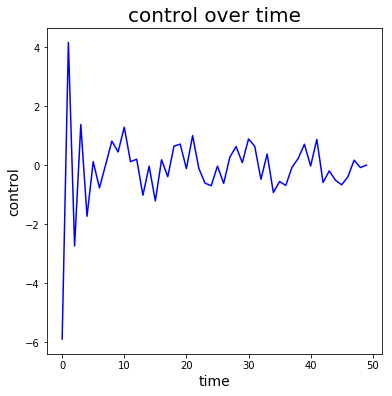

In [13]:
lqr_sine.plot_control(a)

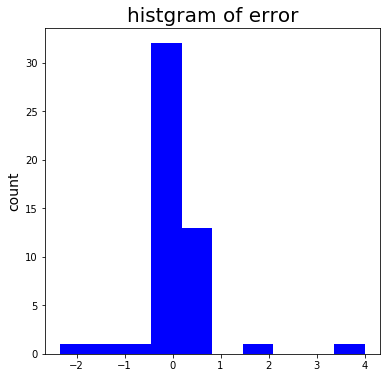

In [14]:
lqr_sine.plot_hist(x)

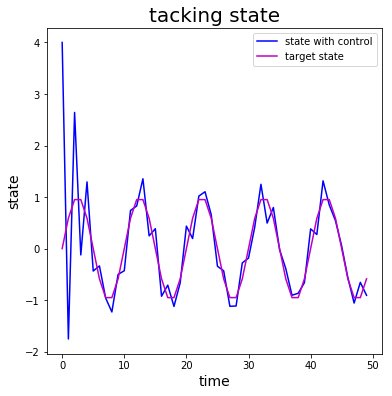

In [15]:
lqr_sine.plot_position(x)

## LQG control of uncertain state with finite time horizon


In the previous examples, a target state is provided. However, in practice, one cannot get access to all the state variables. Then there comes the questions: Can we recover the state variables through the measurable information? 

From yesterday's lecture, it is known that the stataes $\hat{x}$ can be estimated with __Kalman filter__. We can replace the control law in LQR, i.e.

$$a_t = - K^{lqg}_tx_t$$

with the estimated states. 

In [39]:
class KalmanFilter(object):
    def __init__(self, n_state = 1, n_obs = 1, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")
        
        
        self.n_state = n_state
        self.n_obs = n_obs

        self.F = F
        self.H = H
        self.B = np.eye(self.n_state) if B is None else B
        self.Q = np.eye(self.n_state) if Q is None else Q
        self.R = np.eye(self.n_state) if R is None else R
        self.P = np.eye(self.n_state) if P is None else P
        self.x = np.zeros(self.n_state) if x0 is None else x0
        
    def predict(self, u):
        
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

#     def predict(self, u, K, z):
        
#         self.x = np.dot(self.F, self.x) + np.dot(self.B, u) - K* (
#             z - self.H .dot(np.dot(self.F, self.x) + np.dot(self.B, u)))
#         self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
#         return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n_state)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
                        (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)
        
        return K

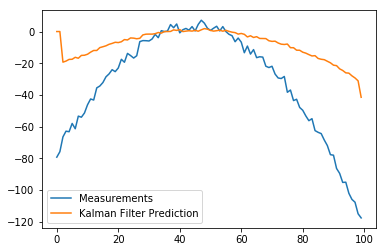

In [64]:
n = 1 #state
m = 1 #obs
D = np.eye(n)
H = np.eye(m)
B = np.eye(m)
process_noise = np.eye(n) 
measurement_noise = np.eye(m)
T = 100

x = np.linspace(-10, 10, T)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

kf = KalmanFilter(n_obs = m, n_state = n, F = D, H = H, Q = process_noise, R = measurement_noise)
predictions = np.zeros(measurements.shape)
states_est = np.zeros(measurements.shape)
#states_est[0] = kf.x


target = np.zeros(T)
lqr = LQR_1D(T, states_est[0], process_noise, target)
control_gain =lqr.control_gain_LQR(D, B, 1, 1)

#control_gain = np.ones(T) * 0

for t in range(1, len(measurements)):
    u = - control_gain[t - 1] * kf.x 
    predictions[t] = (np.dot(H,  kf.predict(u))[0])
    kf.update(measurements[t])
    

import matplotlib.pyplot as plt
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

In [58]:
states_est

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
class MyKalmanFilter():
    def __init__(self, n_dim_state=1, n_dim_obs=1):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = np.eye(n_dim_state)
        self.transition_covariance = np.eye(n_dim_state)
        self.observation_matrices = np.eye(n_dim_obs, n_dim_state)
        self.observation_covariance = np.eye(n_dim_obs)
        self.initial_state_mean = np.zeros(n_dim_state)
        self.initial_state_covariance = np.eye(n_dim_state)
        
        self.control_matrices = np.eye(n_dim_state)
        
    def sample(self, n_timesteps, control_gain, initial_state=None, random_seed=None):
        """
        Method that gives samples
        @param initial_state: numpy array whose length == self.n_dim_state
        @param random_seed: an integer, for test purpose
        @output state: a 2d numpy array with dimension [n_timesteps, self.n_dim_state]
        @output observation: a 2d numpy array with dimension [n_timesteps, self.n_dim_obs]
        """
        # set initial states and seed
        if initial_state is None:
            initial_state = self.initial_state_mean
        if random_seed is not None:
            np.random.seed(random_seed)

        ################
        ##### TODO #####
        ################
        # produce samples
        latent_state = []
        observed_state = []
        current_latent_state = initial_state
        for t in range(n_timesteps):
            # for the first latent state is set to the initial state
            if t == 0:
                latent_state.append(current_latent_state)
            # otherwise use transition_matrices and transition_covariance to calculate next latent state
            else:
                current_control = - control_gain[t] * current_latent_state
                
                latent_state.append(np.dot(self.transition_matrices, current_latent_state) +
                                    np.dot(self.control_matrices, current_control) + 
                                    np.random.multivariate_normal(np.zeros(self.n_dim_state),
                                                                  self.transition_covariance))
                current_latent_state = latent_state[-1]
            # use observation_matrices and observation_covariance to calculate next observed state
            observed_state.append(np.dot(self.observation_matrices, current_latent_state) +
                                  np.random.multivariate_normal(np.zeros(self.n_dim_obs), self.observation_covariance))

        #latent_state = np.zeros([n_timesteps, self.n_dim_state])
        #observed_state = np.zeros([n_timesteps, self.n_dim_obs])
        return np.array(latent_state), np.array(observed_state)
    
    def filter(self, X, control_gain, use_myfilter=True):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """

        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim == self.n_dim_obs

        # create holders for outputs
        filtered_state_means = np.zeros([n_example, self.n_dim_state])
        filtered_state_covariances = np.zeros([n_example, self.n_dim_state, self.n_dim_state])

        #############################
        # TODO: implement filtering #
        #############################
        if use_myfilter:
            # the first state mean and state covar is the initial expectation
            filtered_state_means[0] = self.initial_state_mean
            filtered_state_covariances[0] = self.initial_state_covariance

            # initialize internal variables
            current_state_mean = self.initial_state_mean.copy()
            current_state_covar = self.initial_state_covariance.copy()
            self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
            for i in range(1, n_example):
                current_observed_data = X[i, :]
                # run a single step forward filter
                # prediction step
                predicted_state_mean = np.dot(self.transition_matrices, current_state_mean)
                predicted_state_cov = np.matmul(np.matmul(self.transition_matrices, current_state_covar),
                                                np.transpose(self.transition_matrices)) + self.transition_covariance
                # observation step
                innovation = current_observed_data - np.dot(self.observation_matrices, predicted_state_mean)
                innovation_covariance = np.matmul(np.matmul(self.observation_matrices, predicted_state_cov),
                                                  np.transpose(self.observation_matrices)) + self.observation_covariance
                # update step
                current_control = - control_gain[i] * current_state_mean
                
                kalman_gain = np.matmul(np.matmul(predicted_state_cov, np.transpose(self.observation_matrices)),
                                        np.linalg.inv(innovation_covariance))
                current_state_mean = (predicted_state_mean + np.dot(kalman_gain, innovation) 
                                      + np.dot(self.control_matrices, current_control))
                current_state_covar = np.matmul((np.eye(current_state_covar.shape[0]) -
                                                 np.matmul(kalman_gain, self.observation_matrices)),
                                                predicted_state_cov)
                # populate holders
                filtered_state_means[i, :] = current_state_mean
                filtered_state_covariances[i, :, :] = current_state_covar
                self.p_n_list[i, :, :] = predicted_state_cov
                # self.p_n_list[i-1, :, :] = predicted_state_cov
            # new
            # self.p_n_list[-1, :, :] = np.matmul(np.matmul(self.transition_matrices, filtered_state_covariances[-1,:,:]),
            #                                    np.linalg.inv(self.transition_matrices)) + self.transition_covariance

#         else:
#             #################################################################################
#             # below: this is an alternative if you do not have an implementation of filtering
#             kf = KalmanFilter(n_dim_state=self.n_dim_state, n_dim_obs=self.n_dim_obs)
#             need_params = ['transition_matrices', 'observation_matrices', 'transition_covariance',
#                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
#             for param in need_params:
#                 setattr(kf, param, getattr(self, param))
#             filtered_state_means, filtered_state_covariances = kf.filter(X)
#         #################################################################################

        return filtered_state_means, filtered_state_covariances

In [ ]:
n_dim_state = 1
n_dim_obs = 1

my_kf = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
my_kf.transition_matrices = np.eye(my_kf.n_dim_state)*.9
my_kf.transition_covariance = np.eye(my_kf.n_dim_obs)
my_kf.observation_matrices = np.eye(my_kf.n_dim_state)
my_kf.observation_covariance = np.eye(my_kf.n_dim_obs)
my_kf.initial_state_mean = np.zeros(my_kf.n_dim_state)
my_kf.initial_state_covariance = np.eye(my_kf.n_dim_state)*.1
my_kf.control_matrices = np.eye(my_kf.n_dim_state)

In [ ]:
n_timesteps = 1000
control_gain = np.ones(n_timesteps) * .5
latent, data = my_kf.sample(n_timesteps, control_gain, initial_state=my_kf.initial_state_mean)
filtered_state_means_impl, filtered_state_covariances_impl = my_kf.filter(data, control_gain)
#fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], filtered_state_means_impl[:,0], filtered_state_means_impl[:,1], "r", title ="my kf-filter")
plt.plot(latent,data, 'b.')

plt.axis('square');

In [ ]:
plt.plot(latent, 'b')
plt.plot(data, 'r')

In [ ]:
class LQG_1D(MyKalmanFilter, LQR_1D):
    def __init__(self, T, ini_state, noise_var, target, n_dim_state=1, n_dim_obs=1):
        MyKalmanFilter.__init__(self,n_dim_state=1, n_dim_obs=1)
        LQR_1D.__init__(self,T, ini_state, noise_var, target)   

In [ ]:
noise_var = 0.2
target = np.zeros(n_timesteps)
Q = 1   # cost of state
R = 1   # cost of control
D = my_kf.transition_matrices
B = my_kf.control_matrices

lqg = LQG_1D(n_timesteps, my_kf.initial_state_mean[0], noise_var, target, n_dim_state, n_dim_obs)
L = lqg.control_gain_LQR(Q, B, Q, R)

latent, data = lqg.sample(n_timesteps, L, initial_state=my_kf.initial_state_mean)
filtered_state_means_impl, filtered_state_covariances_impl = lqg.filter(data, L)
#fig = plot_kalman(latent[:,0],latent[:,1],data[:,0],data[:,1], filtered_state_means_impl[:,0], filtered_state_means_impl[:,1], "r", title ="my kf-filter")
plt.plot(latent,data, 'b.')

plt.axis('square');



In [ ]:
plt.plot(latent, 'b')
plt.plot(data, 'r')